# Dataset

In [3]:
import numpy as np
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
  
loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)

In [8]:
index = dataset.edge_index
weight = dataset.edge_weight

In [2]:
print("Dataset type:  ", dataset)
print("Number of samples / sequences: ",  dataset.snapshot_count)

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x7f91f429ca00>
Number of samples / sequences:  34249


In [9]:
dataset.features

[array([[[ 0.53317183,  0.44864222,  0.51461655, ...,  0.48987615,
           0.57509303,  0.4280252 ],
         [-1.7291821 , -1.7171322 , -1.7050823 , ..., -1.6207328 ,
          -1.6086829 , -1.596633  ]],
 
        [[ 0.69398445,  0.74002916,  0.5022464 , ...,  0.3909146 ,
           0.49812302,  0.70016956],
         [-1.7291821 , -1.7171322 , -1.7050823 , ..., -1.6207328 ,
          -1.6086829 , -1.596633  ]],
 
        [[ 0.66924405,  0.5860887 ,  0.3166934 , ...,  0.44039539,
           0.5695954 ,  0.6568738 ],
         [-1.7291821 , -1.7171322 , -1.7050823 , ..., -1.6207328 ,
          -1.6086829 , -1.596633  ]],
 
        ...,
 
        [[ 0.2795828 ,  0.11327237,  0.38472947, ..., -0.14100395,
           0.3441828 ,  0.16825101],
         [-1.7291821 , -1.7171322 , -1.7050823 , ..., -1.6207328 ,
          -1.6086829 , -1.596633  ]],
 
        [[ 0.7620205 ,  0.7345311 ,  0.80443245, ...,  0.62594837,
           0.6740546 ,  0.63831854],
         [-1.7291821 , -1.7171322 , -

## Data sample

In [144]:
# Show first sample
next(iter(dataset))

Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])

In [149]:
# Important: It is not always like that!
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
d = ChickenpoxDatasetLoader().get_dataset(lags=4)
next(iter(d))

Data(x=[20, 4], edge_index=[2, 102], edge_attr=[102], y=[20])

<AxesSubplot:>

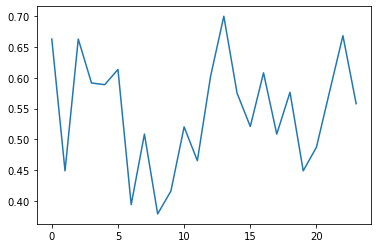

In [150]:
import seaborn as sns
# Visualize traffic over time
sensor_number = 1
hours = 24
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
sns.lineplot(data=sensor_labels)

## Test Train Split

In [172]:
from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

print("Number of train buckets: ", train_dataset.snapshot_count)
print("Number of test buckets: ", test_dataset.snapshot_count)

Number of train buckets:  27399
Number of test buckets:  6850


# Model

In [60]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=32, 
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=2, periods=12)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

# Training

In [61]:
# GPU support
device = torch.device('cpu') # cuda
subset = 2000

# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

print("Running training...")
for epoch in range(10): 
    loss = 0
    step = 0
    for snapshot in train_dataset:
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        # Mean squared error
        loss = loss + torch.mean((y_hat-snapshot.y)**2) 
        step += 1
        if step > subset:
          break

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))

Running training...
Epoch 0 train MSE: 0.7433
Epoch 1 train MSE: 0.7266
Epoch 2 train MSE: 0.7108
Epoch 3 train MSE: 0.6932
Epoch 4 train MSE: 0.6738
Epoch 5 train MSE: 0.6544
Epoch 6 train MSE: 0.6368
Epoch 7 train MSE: 0.6215
Epoch 8 train MSE: 0.6074
Epoch 9 train MSE: 0.5935


# Evaluation

In [62]:
model.eval()
loss = 0
step = 0
horizon = 288

# Store for analysis
predictions = []
labels = []

for snapshot in test_dataset:
    snapshot = snapshot.to(device)
    # Get predictions
    y_hat = model(snapshot.x, snapshot.edge_index)
    # Mean squared error
    loss = loss + torch.mean((y_hat-snapshot.y)**2)
    # Store for analysis below
    labels.append(snapshot.y)
    predictions.append(y_hat)
    step += 1
    if step > horizon:
          break

loss = loss / (step+1)
loss = loss.item()
print("Test MSE: {:.4f}".format(loss))

Test MSE: 0.6900


## Visualization

In [63]:
import numpy as np

sensor = 123
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (289,)


<AxesSubplot:>

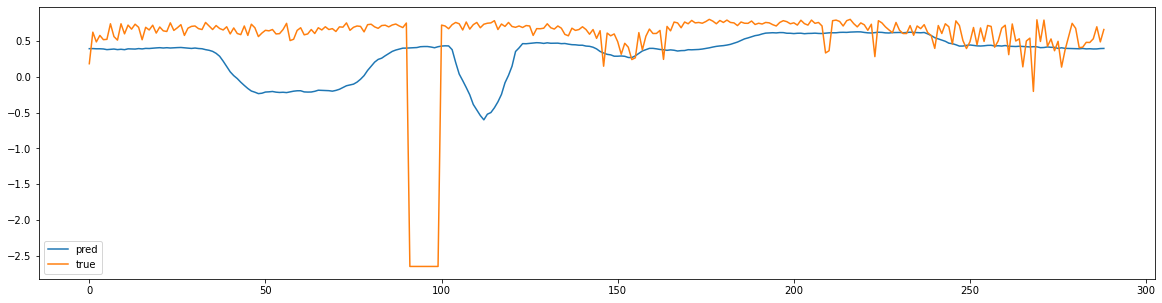

In [64]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")